In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_generation as gen
import torch

## Synthetics generation

In [ ]:
signal, source, stations = gen.signal.generate_one_signal(plot=True)

#### TauP comparison

In [ ]:
# Source characteristics
source_lat = source[0]
source_lon = source[1]
source_depth = source[2]
print(f'Depth : {source_depth/1e3:.3f} km')

# Station position
station_lat = stations[0][0]
station_lon = stations[0][1]

In [ ]:
# My solution
P, pP, sP = gen.arrival_time.travel_times(source_lat, source_lon, source_depth, station_lat, station_lon)
tpP = pP - P
tsP = sP - P

# Results
print(f'P-pP: {tpP:.3f}s - P-sP: {tsP:.3f}s')

In [ ]:
# TauP solution
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees

# Kenett model AK135
model = TauPyModel(model="ak135")

distance_deg = locations2degrees(lat1=source_lat, long1=source_lon,
                                  lat2=station_lat, long2=station_lon)

arrivals = model.get_travel_times(source_depth_in_km=source_depth/1e3,
                                  distance_in_degree=distance_deg,
                                  phase_list=["P", "pP", "sP"])

# Results
tpP = arrivals[1].time - arrivals[0].time
tsP = arrivals[2].time - arrivals[0].time

print(f'P-pP: {tpP:.3f}s - P-sP: {tsP:.3f}s')

#### Generate matrix and plot

In [ ]:
signal_matrix, depth, _ = gen.matrix.generate_matrix()

# Plot
plt.figure(figsize=(10,7))
plt.imshow(signal_matrix, aspect='auto', cmap='viridis', origin='upper')

# Adjust x-axis to represent time in seconds
num_columns = len(signal_matrix[0])  # Number of columns in the matrix
plt.xticks(
    ticks=np.arange(0, num_columns, step=1000),  # Adjust step size as needed
    labels=np.arange(0, num_columns / 100, step=1000 / 100)  # Convert to seconds (1/100 of a second since 100 Hz sampling)
)

#plt.colorbar(label='Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Signals (organized by distance)')
plt.title(f'Energetic envelope of the Z-normalized signals aligned with P-arrival \nDepth : {depth/1e3:.1f} km', fontweight='bold')
plt.tight_layout()
plt.show()

## CNN-DNN model

In [3]:
model, train_data, test_data = gen.depth_model.train_DepthModel(batch_size=32, num_stations=50, epochs=100, include_distance=True)

Succesfully generated train dataset.
Succesfully generated test dataset.
Succesfully initialized model using cuda.
Succesfully set loss criterion and optimizer.
Epoch 1/100, Mean Loss: 2733339648.0000
Epoch 2/100, Mean Loss: 2729517568.0000
Epoch 3/100, Mean Loss: 2718565376.0000
Epoch 4/100, Mean Loss: 2698604544.0000
Epoch 5/100, Mean Loss: 2664985856.0000
Epoch 6/100, Mean Loss: 2610760192.0000
Epoch 7/100, Mean Loss: 2529190400.0000
Epoch 8/100, Mean Loss: 2411410944.0000
Epoch 9/100, Mean Loss: 2249028352.0000
Epoch 10/100, Mean Loss: 2032479104.0000
Epoch 11/100, Mean Loss: 1756553728.0000
Epoch 12/100, Mean Loss: 1426650368.0000
Epoch 13/100, Mean Loss: 1070548224.0000
Epoch 14/100, Mean Loss: 752950912.0000
Epoch 15/100, Mean Loss: 598887040.0000
Epoch 16/100, Mean Loss: 718891584.0000
Epoch 17/100, Mean Loss: 848974144.0000
Epoch 18/100, Mean Loss: 736724864.0000
Epoch 19/100, Mean Loss: 538634880.0000
Epoch 20/100, Mean Loss: 401924992.0000
Epoch 21/100, Mean Loss: 345555456.

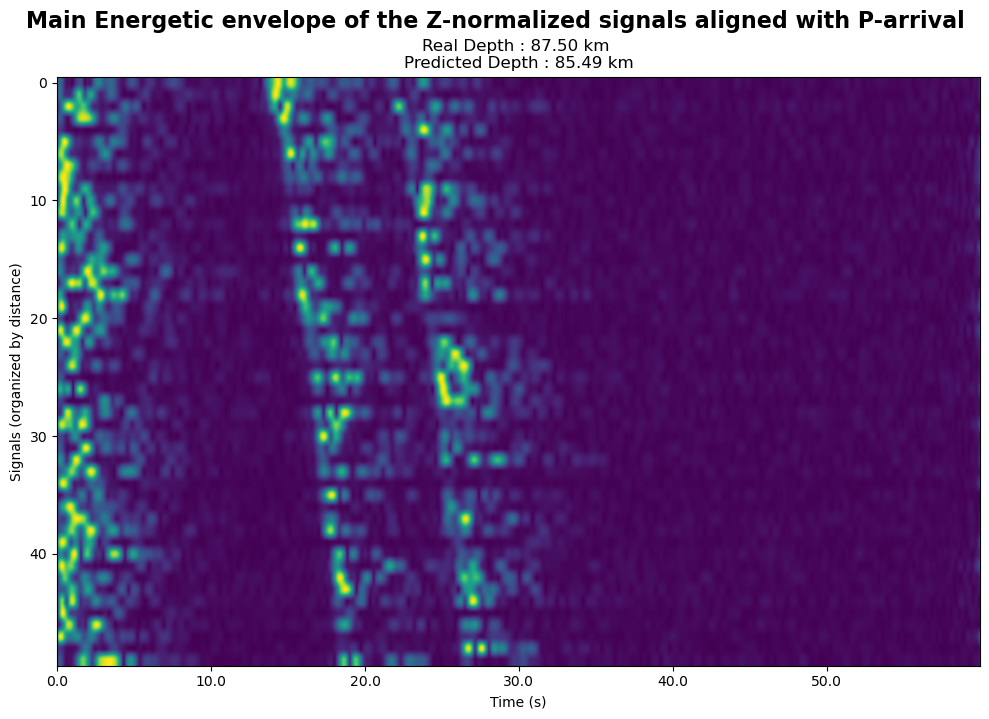

In [2]:
predicted_depth = gen.depth_model.run_DepthModel(batch_size=32, num_stations=50, epochs=100, include_distance=True)